In [8]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Task: Fine-tuning a Pre-trained Image Classifier for Flower Classification

## Step-1: Data Preparation:


In [10]:
X = []
Z = []
img_size = 150
flower_daisy_dir='/content/drive/MyDrive/Deep Learning/project3/flowers/daisy'
flower_sunflower_dir = '/content/drive/MyDrive/Deep Learning/project3/flowers/sunflower'
flower_tulip_dir = '/content/drive/MyDrive/Deep Learning/project3/flowers/tulip'
flower_dandi_dir = '/content/drive/MyDrive/Deep Learning/project3/flowers/dandelion'
flower_rose_dir = '/content/drive/MyDrive/Deep Learning/project3/flowers/rose'


- X will hold the image data
- Z will hold the corresponding labels. for example: if the image contains the daisy flower it is labled as daisy
- img_size is set to 150, indicating that all images will be resized to a square with dimensions 150x150 pixels.

In [11]:
def assign_label(img, flower_type):
  return flower_type

- This function takes an image and a flower type as input and returns the flower type as the label.

In [12]:
def make_train_data(flower_type, dir):
  for img in tqdm(os.listdir(dir)):
    label = assign_label(img, flower_type)
    path = os.path.join(dir, img)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_size, img_size))

    X.append(np.array(img))
    Z.append(str(label))

- This function takes the flower type and its directory as input, iterates over all images in that directory, assigns labels using assign_label, reads and resizes each image, and then appends the image data and corresponding label to lists X and Z, respectively.

In [13]:
make_train_data('Daisy', flower_daisy_dir )
make_train_data('Sunflower', flower_sunflower_dir )
make_train_data('Tulip', flower_tulip_dir )
make_train_data('Dandi', flower_dandi_dir )
make_train_data('Rose', flower_rose_dir )
print()
print(len(X))

100%|██████████| 784/784 [00:37<00:00, 20.72it/s] 


4317


The total number of records (from the original file) is 4,317 entries (flowers).
Label encoding your Y variable (Daisy → 0, Rose → 1, etc.…)

In [14]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y,5)

- this code prepares the labels for training a  model by first converting categorical labels into numerical labels using label encoding, and then  numerical labels to create a format which is suitable for training a classification model by one-hot encoding

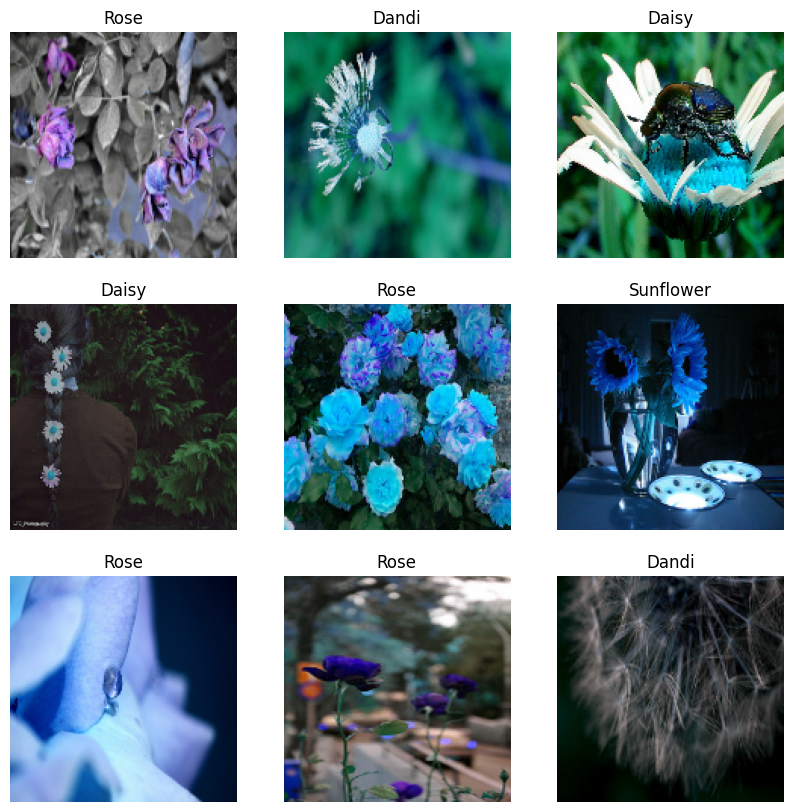

In [19]:
import matplotlib.pyplot as plt

# Define a function to display sample images
def visualize_data(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

import random

# Combine X and Z into a list of tuples
data = list(zip(X, Z))

# Shuffle the data
random.shuffle(data)

# Split the shuffled data back into X and Z
X_shuffled, Z_shuffled = zip(*data)

# Display shuffled sample images
visualize_data(X_shuffled, Z_shuffled)


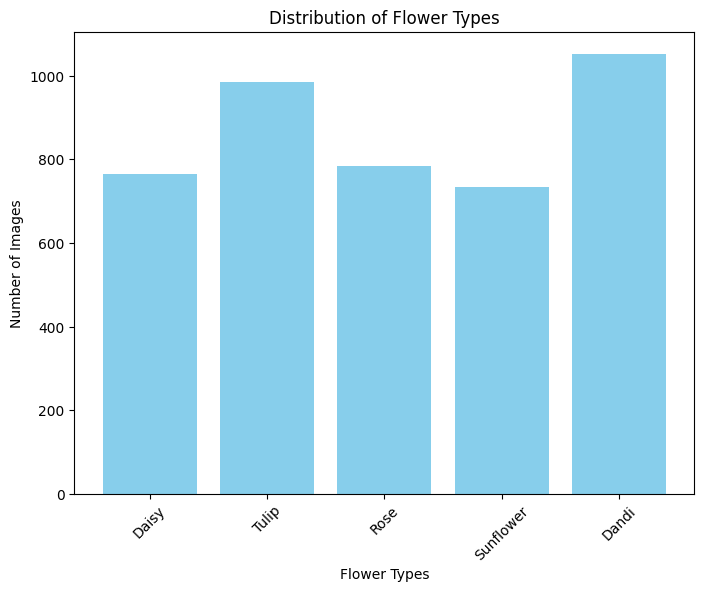

In [17]:
import matplotlib.pyplot as plt

# Count the occurrences of each class
class_counts = {label: Z.count(label) for label in set(Z)}

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Flower Types')
plt.ylabel('Number of Images')
plt.title('Distribution of Flower Types')
plt.xticks(rotation=45)
plt.show()


Next, split into ‘training’ and ‘test’ dataset in 75/25 ratio:

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


In [ ]:
# Convert lists to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

# Now you can access the shape attribute
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (3237, 150, 150, 3)
X_test shape: (1080, 150, 150, 3)
Y_train shape: (3237, 5)
Y_test shape: (1080, 5)


## Step-2: Selecting a Pre-trained Model:


In [ ]:
# Step 2: Selecting a Pre-trained Model (ResNet50)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

In [ ]:
# Adding custom layers for flower classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Combining the base model with custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Evaluate the base model on the test set
base_model_loss, base_model_accuracy = model.evaluate(X_test, Y_test)
print("Base Model Test Loss:", base_model_loss)
print("Base Model Test Accuracy:", base_model_accuracy)

34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 310ms/step - accuracy: 0.2301 - loss: 2.2502
Base Model Test Loss: 2.2347285747528076
Base Model Test Accuracy: 0.22777777910232544


- To know the performance of the pre-trained model bfore training I have Loaded a pre-trained ResNet50 model.
- Customized the model for flower classification by adding custom layers on top of the pre-trained model.
- Freezed the pre-trained layers to prevent them from being updated.
- Compiled the model using the Adam optimizer, categorical cross-entropy loss function, and accuracy metric.
- Evaluated the performance of the model on the test set.
- Obtained an accuracy of 16% with a test loss of 25.04.

## Step-3: Implementing Transfer Learning in TensorFlow:


In [ ]:

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the pre-trained layers so they are not trainable
for layer in base_model.layers:
  layer.trainable = False

# Add a new fully connected layer for flower classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_test, Y_test), batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 24,769,413 (94.49 MB)

 Trainable params: 1,181,701 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 45s 426ms/step - accuracy: 0.7009 - loss: 0.8636 - val_accuracy: 0.8685 - val_loss: 0.3644
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 424ms/step - accuracy: 0.9058 - loss: 0.2586 - val_accuracy: 0.8472 - val_loss: 0.4525
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.9399 - loss: 0.1760 - val_accuracy: 0.8722 - val_loss: 0.3707
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.9613 - loss: 0.1156 - val_accuracy: 0.8778 - val_loss: 0.3823
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 425ms/step - accuracy: 0.9845 - loss: 0.0493 - val_accuracy: 0.8556 - val_loss: 0.5233
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 423ms/step - accuracy: 0.9816 - loss: 0.0622 - val_accuracy: 0.8870 - val_loss: 0.4551
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 425ms/step - accuracy: 0.9960 - loss: 0.0167 - val_accuracy: 0.8926 - val_loss: 0.4590
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 426ms/step - accuracy: 0.9932 - loss: 0

- A pre-trained ResNet50 model is loaded with weights pretrained on ImageNet data.
- The pre-trained layers are frozen  for each layer in the model. This prevents their weights from being updated during training.
- Custom layers for flower classification are added on top of the pre-trained ResNet50 model. These include a global average pooling layer and two dense (fully connected) layers with ReLU and softmax activations respectively. The softmax activation in the final layer ensures that the output represents class probabilities.
- The model is compiled using the Adam optimizer, categorical cross-entropy loss function, and accuracy metric.
- The model is trained  using the training data  for 20 epochs with a batch size of 32. Validation data  is provided to monitor the model's performance on unseen data during training.
- After training, the model is evaluated on the test set.
- Achieved a test loss of 0.6485 and an accuracy of 88.05%.

In [ ]:
# model.save("/content/drive/MyDrive/Deep Learning/project3/tf_model01.h5")

In [ ]:
# Make predictions
Y_pred = model.predict(X_test)
# Convert predictions to one-hot encoded labels
Y_pred_labels = np.argmax(Y_pred, axis=1)
# Convert true labels to one-hot encoded labels
Y_true_labels = np.argmax(Y_test, axis=1)

34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 335ms/step


In [ ]:
# Accuracy
accuracy = accuracy_score(Y_true_labels, Y_pred_labels)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(Y_true_labels, Y_pred_labels, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(Y_true_labels, Y_pred_labels, average='weighted')
print("Recall:", recall)

# F1-score
f1 = f1_score(Y_true_labels, Y_pred_labels, average='weighted')
print("F1-score:", f1)

Accuracy: 0.8805555555555555
Precision: 0.8812531736938947
Recall: 0.8805555555555555
F1-score: 0.8805424244732573


Tensorflow Model Results:
--------------------------------------------------
Training Loss: 0.0013
Validation Loss: 0.6485


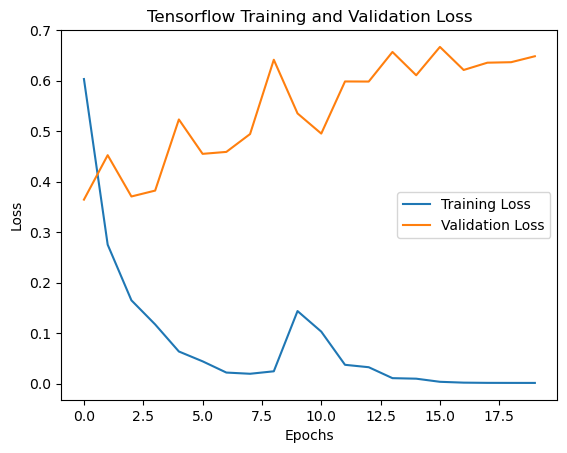

In [ ]:
def plot_loss(history, model_name):
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    # Print results
    print(f"{model_name} Model Results:")
    print("-" * 50)
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history, 'Tensorflow')

- The graph displays the validation and training loss trends throughout the training process

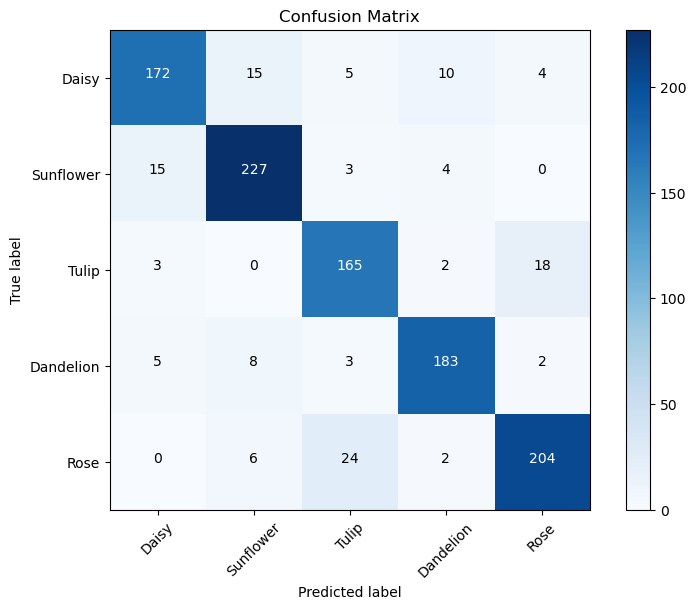

In [ ]:
import itertools
# Confusion matrix
conf_matrix = confusion_matrix(Y_true_labels, Y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Daisy', 'Sunflower', 'Tulip', 'Dandelion', 'Rose']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j],
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


- The model correctly classified 173 Daisy flowers, but it misclassified 15 sunflowers, 5 tulip, 10 dandelion,4 rose.
- The model correctly classified 227 sunflower flowers, but it misclassified 15 daisy, 3 tulip, 4 dandelion.
- The model correctly classified 165 tulip flowers, but it misclassified 3 daisy, 2 dandelion,18 rose.
- The model correctly classified 183 dandelion flowers, but it misclassified 8 sunflowers, 3 tulip, 5 daisy,2 rose.
- The model correctly classified 204 rose flowers, but it misclassified 6 sunflowers, 24 tulip, 2 dandelion.

## Step-4: Implementing Transfer Learning in PyTorch:


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications import ResNet50
from torch.utils.data import TensorDataset


# Define the model architecture and freeze pre-trained layers
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 5)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Only include parameters of the last layer (classifier)
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)


# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Convert data to tensors and create dataloader
X_train_tensor = torch.tensor(X_train.transpose(0,3,1,2)).float()
Y_train_tensor = torch.tensor(Y_train).long()

# Create custom datasets and data loaders
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


X_test_tensor = torch.tensor(X_test.transpose(0,3,1,2)).float()
Y_test_tensor = torch.tensor(np.argmax(Y_test, axis=1))
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Training the model
def train_model(model, criteraion, optimizer, num_epochs=20):
  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels.max(dim=1)[1])
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

train_model(resnet, criterion, optimizer)


/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 0.8077657719453176
Epoch [2/20], Loss: 0.5533583579110164
Epoch [3/20], Loss: 0.5004187522857797
Epoch [4/20], Loss: 0.4475869225228534
Epoch [5/20], Loss: 0.42402658100221674
Epoch [6/20], Loss: 0.43150779882482454
Epoch [7/20], Loss: 0.43532029203340117
Epoch [8/20], Loss: 0.40507792820240934
Epoch [9/20], Loss: 0.3613663106864574
Epoch [10/20], Loss: 0.3540980731155358
Epoch [11/20], Loss: 0.3602930591167772
Epoch [12/20], Loss: 0.34511585687013235
Epoch [13/20], Loss: 0.35725310313351016
Epoch [14/20], Loss: 0.3178078808328685
Epoch [15/20], Loss: 0.3069564935331251
Epoch [16/20], Loss: 0.32521356057886985
Epoch [17/20], Loss: 0.3111662038547151
Epoch [18/20], Loss: 0.33205137982526245
Epoch [19/20], Loss: 0.2945016816112341
Epoch [20/20], Loss: 0.32219141429545833


- It uses TensorDataset to create datasets directly from tensors without defining a custom dataset class.It also includes additional preprocessing steps like image resizing.
- Transformations for data augmentation and normalization are defined. These transformations include converting images to tensors and normalizing them using mean and standard deviation values.
- Custom datasets (train_dataset and test_dataset) are created using the FlowerDataset class, along with their corresponding data loaders (train_loader and test_loader). These data loaders handle batching, shuffling, and loading of the data during training and testing.
- The ResNet-50 model is loaded with pretrained weights and the fully connected layer is replaced with a new linear layer to adapt the model for flower classification.
- Pre-trained layers are frozen  for all parameters except the parameters of the final layer.
- Cross-entropy loss is chosen as the loss function, and Adam optimizer is used to optimize the model parameters.
- The model is trained for 20  epochs using a loop over the training data.
-  After training, the model is switched to evaluation mode. Predictions are made using the trained model, and the true and predicted labels are collected and achieved the accuracy of 83.61%.



In [ ]:
import torch

def predict_all(model, data_loader):
  model.eval()
  all_preds =[]
  all_labels = []
  with torch.no_grad():
    for images, labels in data_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      all_preds.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
  return all_labels, all_preds

labels, predictions = predict_all(resnet, test_loader)

In [ ]:
# Calculate classification metrics
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions, average='weighted')
recall = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8361
Precision: 0.8526
Recall: 0.8361
F1-score: 0.8382


**Note :**
- **Earlier, A custom dataset class FlowerDataset is defined, which inherits from the PyTorch Dataset class. This class handles loading and preprocessing of the flower dataset and achived the accuracy of only 20%.**
- **Later, The data handling is simplified. It uses TensorDataset to create datasets directly from tensors without defining a custom dataset class.It also includes additional preprocessing steps like image resizing. This Difference made Huge Change in achieveing accutacy of 83%**

# Comparison of TensorFlow and Pytorch:

- The TensorFlow achieved a higher accuracy compared to the Pytorch model.

- The TensorFlow also utilized additional layers specifically tailored for flower classification on top of the pre-trained ResNet50 model. These custom layers might have contributed to the improved accuracy by providing more flexibility in feature extraction and classification.

- Both models froze the pre-trained layers, ensuring that the weights learned from ImageNet data were retained. This approach helps in leveraging the knowledge learned from a large dataset (ImageNet) for the specific task of flower classification.

- Both models used the Adam optimizer and cross-entropy loss function, indicating consistency in the optimization and evaluation approaches.


## Conclusion:

- The TensorFlow, with its additional custom layers, outperformed the first model in terms of accuracy.
- The additional preprocessing steps such as image resizing and normalization m have contributed to the improved performance in the Pytorch.
- Overall, TensorFlow demonstrates better performance and efficacy for the task of flower classification compared to the Pytorch.